## Item Similarity-based Collaborative Filtering Model

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#from sklearn import cross_validation, linear_model
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans
from sklearn import datasets
import random
import time
import pylab as pl

In [2]:
df = pd.read_parquet('/Users/macbookpro16/Desktop/user_track_df.parquet', engine='pyarrow')
df.head()

,user_id,song_id,listen_count,track_id,artist_name,track_name,track_uri,popularity,duration_ms,explicit,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_id
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2,TRPLAXZ128F4292406,Jorge Drexler,12 segundos de oscuridad,2ECKXkpPAxky87ohawpaeD,37,246826,0,...,-8.176,0,0.0327,0.11900,0.000412,0.103,0.0396,126.051,4,4ssUf5gLb1GBLxi1BhPrVt
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRHNCIR128F42334A5,Kanye West,Stronger,4fzsfWzRhPawzqhX8Qt9F3,82,311867,1,...,-7.858,0,0.1530,0.00564,0.000000,0.408,0.4900,103.992,4,5K4W6rqBFWDnAN6FQUkS6x
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRUATNS128F423457D,Kanye West,Stronger,4fzsfWzRhPawzqhX8Qt9F3,82,311867,1,...,-7.858,0,0.1530,0.00564,0.000000,0.408,0.4900,103.992,4,5K4W6rqBFWDnAN6FQUkS6x
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,TRYBNIB128F428E704,Jack Johnson,Constellations,3deZQXBY8CJFbrTc2PbU34,59,201640,0,...,-12.640,1,0.0355,0.46800,0.000043,0.117,0.4430,122.012,4,3GBPw9NK25X1Wt2OUvOwY3
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOEWFWM12A8C1308BA,1,TRLQPQJ128F42AA94F,Gipsy Kings,Soy,076jKe7yfP979o1QLKMIA2,47,189987,0,...,-12.321,0,0.0653,0.29700,0.000267,0.127,0.9050,114.656,4,3jc496ljiyrS3ECrD7QiqL


In [3]:
#only taking 500000 rows for the sake of memory and time
similarity_df = df.head(500000)
similarity_df

,user_id,song_id,listen_count,track_id,artist_name,track_name,track_uri,popularity,duration_ms,explicit,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_id
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2,TRPLAXZ128F4292406,Jorge Drexler,12 segundos de oscuridad,2ECKXkpPAxky87ohawpaeD,37,246826,0,...,-8.176,0,0.0327,0.119000,0.000412,0.1030,0.0396,126.051,4,4ssUf5gLb1GBLxi1BhPrVt
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRHNCIR128F42334A5,Kanye West,Stronger,4fzsfWzRhPawzqhX8Qt9F3,82,311867,1,...,-7.858,0,0.1530,0.005640,0.000000,0.4080,0.4900,103.992,4,5K4W6rqBFWDnAN6FQUkS6x
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRUATNS128F423457D,Kanye West,Stronger,4fzsfWzRhPawzqhX8Qt9F3,82,311867,1,...,-7.858,0,0.1530,0.005640,0.000000,0.4080,0.4900,103.992,4,5K4W6rqBFWDnAN6FQUkS6x
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,TRYBNIB128F428E704,Jack Johnson,Constellations,3deZQXBY8CJFbrTc2PbU34,59,201640,0,...,-12.640,1,0.0355,0.468000,0.000043,0.1170,0.4430,122.012,4,3GBPw9NK25X1Wt2OUvOwY3
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOEWFWM12A8C1308BA,1,TRLQPQJ128F42AA94F,Gipsy Kings,Soy,076jKe7yfP979o1QLKMIA2,47,189987,0,...,-12.321,0,0.0653,0.297000,0.000267,0.1270,0.9050,114.656,4,3jc496ljiyrS3ECrD7QiqL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,98f9804ccbbf2696b5c8f3a5d3f971118dc78e1f,SOHSXAV12A67ADF7E7,1,TRXYEKR128E079654C,Morcheeba,Otherwise,0NTSwjegwCGXjm5zMX12VW,56,222840,0,...,-7.555,0,0.0313,0.276000,0.000005,0.3200,0.5960,148.056,4,6bWxFw65IEJzBYjx3SxUXd
499996,98f9804ccbbf2696b5c8f3a5d3f971118dc78e1f,SOIMQAK12A67ADE98C,1,TRPFLRB128F14A895D,Arcade Fire,No Cars Go,51xBgzcyzojRpqFW2ICQAB,58,343627,0,...,-6.950,1,0.0371,0.000609,0.173000,0.1200,0.2910,135.737,4,3kjuyTCjPG1WMFCiyc5IuB
499997,98f9804ccbbf2696b5c8f3a5d3f971118dc78e1f,SOINIUZ12A67ADF6D8,1,TRTCMKQ128E079654D,Morcheeba,Blindfold,7xgfSlAPUouBAquQZkAUdq,49,278680,0,...,-6.738,1,0.0348,0.028100,0.027400,0.0555,0.2150,161.949,4,6bWxFw65IEJzBYjx3SxUXd
499998,98f9804ccbbf2696b5c8f3a5d3f971118dc78e1f,SOIQHPL12A6701F061,1,TRNBNSJ128E0784B67,Moby,In This World,70evTHsBFgs1AKhC5URcCz,60,242520,0,...,-6.646,1,0.0416,0.015700,0.008830,0.2850,0.2760,104.957,4,3OsRAKCvk37zwYcnzRf5XF


In [4]:
#splitting into train and test data
train_data_similarity, test_data_similarity = train_test_split(similarity_df, test_size = 0.20, random_state=0)

In [16]:
#Class for Item similarity based Recommender System model
class item_similarity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.cooccurence_matrix = None
        self.songs_dict = None
        self.rev_songs_dict = None
        self.item_similarity_recommendations = None
        
    #Get unique items (songs) corresponding to a given user
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.item_id].unique())
        
        return user_items
        
    #Get unique users for a given item (song)
    def get_item_users(self, item):
        item_data = self.train_data[self.train_data[self.item_id] == item]
        item_users = set(item_data[self.user_id].unique())
            
        return item_users
        
    #Get unique items (songs) in the training data
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.item_id].unique())
            
        return all_items
        
    #Construct cooccurence matrix
    def construct_cooccurence_matrix(self, user_songs, all_songs):
            
        ####################################
        #Get users for all songs in user_songs.
        ####################################
        user_songs_users = []        
        for i in range(0, len(user_songs)):
            user_songs_users.append(self.get_item_users(user_songs[i]))
            
        ###############################################
        #Initialize the item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)
           
        #############################################################
        #Calculate similarity between user songs and all unique songs
        #in the training data
        #############################################################
        for i in range(0,len(all_songs)):
            #Calculate unique listeners (users) of song (item) i
            songs_i_data = self.train_data[self.train_data[self.item_id] == all_songs[i]]
            users_i = set(songs_i_data[self.user_id].unique())
            
            for j in range(0,len(user_songs)):       
                    
                #Get unique listeners (users) of song (item) j
                users_j = user_songs_users[j]
                    
                #Calculate intersection of listeners of songs i and j
                users_intersection = users_i.intersection(users_j)
                
                #Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:
                    #Calculate union of listeners of songs i and j
                    users_union = users_i.union(users_j)
                    
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0
                    
        
        return cooccurence_matrix

    
    #Use the cooccurence matrix to make top recommendations
    def generate_top_recommendations(self, user, cooccurence_matrix, all_songs, user_songs):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
        
        #Calculate a weighted average of the scores in cooccurence matrix for all user songs.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
 
        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Create a dataframe from the following
        columns = ['user_id', 'song_id', 'score', 'rank']
        #index = np.arange(1) # array of numbers for the number of samples
        df = pd.DataFrame(columns=columns)
         
        #Fill the dataframe with top 10 item based recommendations
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no songs for training the item similarity based recommendation model.")
            return -1
        else:
            return df
 
    #Create the item similarity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

    #Use the item similarity based recommender system model to
    #make recommendations
    def recommend(self, user):
        
        ########################################
        #A. Get all unique songs for this user
        ########################################
        user_songs = self.get_user_items(user)    
            
        print("No. of unique songs for the user: %d" % len(user_songs))
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
                
        return df_recommendations
    
    #Get similar items to given items
    def get_similar_items(self, item_list):
        
        user_songs = item_list
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
         
        return df_recommendations

In [17]:
is_model = item_similarity_recommender_py()

In [18]:
is_model.create(train_data_similarity, 'user_id', 'song_id')

In [19]:
#Print the songs for the user in training data
user_id = df['user_id'][5]
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: b80344d063b5ccb3212f76538f3d9e43d87dca9e:
------------------------------------------------------------------------------------
SOBXHDL12A81C204C0
SOWEZSI12A81C21CE6
SOXZQDE12A8C135833
SOSYBEV12AB0182933
SORWLTW12A670208FA
SONRXOY12AB0181E84
SORUFVF12AB018230B
SOJPFQG12A58A7833A
SOXSPON12A6D4F5DC2
SOLUHPJ12A8C13AB0F
SOMSQJY12A8C138539
SOTRSFZ12A8C142BF6
SOBSUJE12A6D4F8CF5
SOJTEDZ12A58A7CB3D
SORPMYJ12AF729EB90
SOQIVUD12AB01821D2
SOMLMKI12A81C204BC
SOBYHAJ12A6701BF1D
SOVHRGF12A8C13852F
SOEWFWM12A8C1308BA
SOUKXIN12A8C133C7F
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 21
no. of unique songs in the training set: 14623
Non zero values in cooccurence_matrix :30078


,user_id,song_id,score,rank
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFZARF12A81C21CED,0.031399,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODMETA12A42806445,0.026934,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOTBEMN12A58A7B6F7,0.025781,3
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOKDUNP12A81C21CF0,0.023926,4
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFGUAY12AB017B0A8,0.022771,5
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOUNLRE12A8C132E78,0.020545,6
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOVLNNR12AB017EF32,0.020408,7
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOGHSQA12A8C14098E,0.020183,8
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOKLVUI12A6701BF1B,0.019759,9
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOOGZYY12A6701D9CB,0.019736,10


In [10]:
is_model.get_similar_items(['SOTWNDJ12A8C143984'])

no. of unique songs in the training set: 14623
Non zero values in cooccurence_matrix :4588


,user_id,song,score,rank
0,,SONYKOW12AB01849C9,0.198925,1
1,,SODGVGW12AC9075A8D,0.161524,2
2,,SOKLRPJ12A8C13C3FE,0.141129,3
3,,SOTWSXL12A8C143349,0.126562,4
4,,SOUFPNI12A8C142D19,0.114273,5
5,,SOCVTLJ12A6310F0FD,0.100850,6
6,,SOLRGVL12A8C143BC3,0.097029,7
7,,SODLLYS12A8C13A96B,0.093067,8
8,,SOANQFY12AB0183239,0.092735,9
9,,SOXWYZP12AF72A42A6,0.091441,10


In [20]:
class precision_recall_calculator():
    
    def __init__(self, test_data, train_data, is_model):
        self.test_data = test_data
        self.train_data = train_data
        self.user_test_sample = None
        self.model2 = is_model
        
        self.ism_training_dict = dict()
        self.test_dict = dict()
    
    #Method to return random percentage of values from a list
    def remove_percentage(self, list_a, percentage):
        k = int(len(list_a) * percentage)
        random.seed(0)
        indicies = random.sample(range(len(list_a)), k)
        new_list = [list_a[i] for i in indicies]
    
        return new_list
    
    #Create a test sample of users for use in calculating precision
    #and recall
    def create_user_test_sample(self, percentage):
        #Find users common between training and test set
        users_test_and_training = list(set(self.test_data['user_id'].unique()).intersection(set(self.train_data['user_id'].unique())))
        print("Length of user_test_and_training:%d" % len(users_test_and_training))

        #Take only random user_sample of users for evaluations
        self.users_test_sample = self.remove_percentage(users_test_and_training, percentage)

        print("Length of user sample:%d" % len(self.users_test_sample))
        
    #Method to generate recommendations for users in the user test sample
    def get_test_sample_recommendations(self):
        #For these test_sample users, get top 10 recommendations from training set
        #self.ism_training_dict = {}
        #self.pm_training_dict = {}

        #self.test_dict = {}

        for user_id in self.users_test_sample:
            #Get items for user_id from item similarity model
            print("Getting recommendations for user:%s" % user_id)
            user_sim_items = self.model2.recommend(user_id)
            self.ism_training_dict[user_id] = list(user_sim_items["song_id"])
    
            #Get items for user_id from test_data
            test_data_user = self.test_data[self.test_data['user_id'] == user_id]
            self.test_dict[user_id] = set(test_data_user['song_id'].unique() )
    
    #Method to calculate the precision and recall measures
    def calculate_precision_recall(self):
        #Create cutoff list for precision and recall calculation
        cutoff_list = list(range(1,11))


        #For each distinct cutoff:
        #    1. For each distinct user, calculate precision and recall.
        #    2. Calculate average precision and recall.

        ism_avg_precision_list = []
        ism_avg_recall_list = []


        num_users_sample = len(self.users_test_sample)
        for N in cutoff_list:
            ism_sum_precision = 0
            ism_sum_recall = 0
            ism_avg_precision = 0
            ism_avg_recall = 0

            for user_id in self.users_test_sample:
                ism_hitset = self.test_dict[user_id].intersection(set(self.ism_training_dict[user_id][0:N]))
                testset = self.test_dict[user_id]
        
                ism_sum_precision += float(len(ism_hitset))/float(len(testset))
                ism_sum_recall += float(len(ism_hitset))/float(N)
        
    
            ism_avg_precision = ism_sum_precision/float(num_users_sample)
            ism_avg_recall = ism_sum_recall/float(num_users_sample)

            ism_avg_precision_list.append(ism_avg_precision)
            ism_avg_recall_list.append(ism_avg_recall)

            
        return (ism_avg_precision_list, ism_avg_recall_list)
     

    #A wrapper method to calculate all the evaluation measures
    def calculate_measures(self, percentage):
        #Create a test sample of users
        self.create_user_test_sample(percentage)
        
        #Generate recommendations for the test sample users
        self.get_test_sample_recommendations()
        
        #Calculate precision and recall at different cutoff values
        #similarity model (ism)
        
        return self.calculate_precision_recall()
        #return (ism_avg_precision_list, ism_avg_recall_list)    

In [22]:
start = time.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.05

#Instantiate the precision_recall_calculator class
pr = precision_recall_calculator(test_data_similarity.head(1000), train_data_similarity.head(1000), is_model)

#Call method to calculate precision and recall values
(ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

Length of user_test_and_training:60
Length of user sample:3
Getting recommendations for user:89de0abbecc5adf1e78b66ab0a2f126db1543aba
No. of unique songs for the user: 20
no. of unique songs in the training set: 14623
Non zero values in cooccurence_matrix :62778
Getting recommendations for user:1923c9456e685c909c2e82355e9f35e3652b29f4
No. of unique songs for the user: 51
no. of unique songs in the training set: 14623
Non zero values in cooccurence_matrix :86135
Getting recommendations for user:695179610d0b1fbb9d66267a3bd24946617af7fb
No. of unique songs for the user: 38
no. of unique songs in the training set: 14623
Non zero values in cooccurence_matrix :131839
1377.1373088359833


In [23]:
#Method to generate precision and recall curve
def plot_precision_recall(m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()

Plotting precision recall curves.


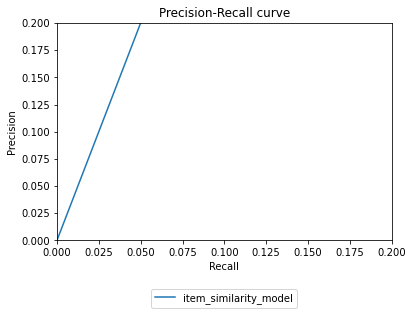

In [27]:
print("Plotting precision recall curves.")

plot_precision_recall(ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")